Boucle globale de lecture de vidéo


state= 0
    img_calibration
    obstacle detection
    start and goal
    global_nav
    
state = 1
    img_calibration
    detect Thymio
    astolfi ou local nav
    
    

In [1]:
#lancer la communication asynchrone avec thymio
from tdmclient import ClientAsync, aw
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

#vérifier d'avoir installer pyserial

Node eb16048f-962c-44b2-9651-cc3b67bca83b

# Initialisation

In [2]:
#check each import if it's really necessary
import cv2 
import time
import numpy as np
from PIL import Image 
import math
import matplotlib
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt

#import from global control
#import from glocal + control
import pyvisgraph as vg
import geopandas as gpd
from geopandas import GeoSeries
from shapely.geometry import Polygon, Point, LineString
import time

In [3]:
import Vision as vis
import Global as glob
import control as ctrl
import local_nav as local

# fonction et classe filtering
from kalman_step_astolfi import kalman_step_complet
from EKF_astolfi import ExtendedKalmanFilterAstolfi

In [ ]:
#pour le test utilise une image mais en vrai relier à la caméra et temps réel

cap=cv2.VideoCapture(1,cv2.CAP_DSHOW)

for i in range (5):
    _, frame = cap.read()
    time.sleep(1)
    print("frame {}".format(i))

cap.release()


#img_final= cv2.flip(img_final, 0)
img_final2 = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
corner_coord=vis.find_corners(img_final2)
img=vis.img_calibration(img_final2,corner_coord)
#cv2.imwrite('warpped.png', zzz)
plt.figure()
plt.imshow(img)
plt.show()



In [ ]:
#obstacle detection
polygons=vis.obstacle_detection(img)
#Start and goal detection
start=vis.detectCircle(img,'start')
goal=vis.detectCircle(img,'goal')

In [ ]:
#plot the visibility graph

#a voir si on le met dedans
margin = 35
path=glob.global_pathplanning(start,goal,polygons,margin)


# Control and navigation loop

In [ ]:
#cap=cv2.VideoCapture(0)

In [ ]:
cap=cv2.VideoCapture(1,cv2.CAP_DSHOW)

for i in range (5):
    _, frame = cap.read()
    time.sleep(1)
    print("frame {}".format(i))

cap.release()
    
#frame=vis.img_calibration(frame)
    
plt.figure()
plt.imshow(frame)
plt.show()

In [ ]:
#img_final = cv2.imread(frame)
img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#img= cv2.flip(img, 0)
final=vis.img_calibration(img)
plt.figure()
plt.imshow(final)
plt.show()

In [4]:
def initialisation(pic):
    #obstacle detection
    polygons=vis.obstacle_detection(pic)
    #Start and goal detection
    start=vis.detectCircle(pic,'start')
    goal=vis.detectCircle(pic,'goal')
    init=[start,goal,polygons]
    return init



In [5]:
def printThymio(posThym, coordThym):
    coordThym.append((round(pos_thym[0]),round(pos_thym[1]))) #pos_thym = [x,y]
    for i in range(0,len(coordThym)):
        cv2.circle(final,(int(coordThym[i][0]),int(coordThym[i][1])), int(3), (0,255,255), 2)

In [6]:
def printThymioKalm(posThym, coordThym):    #la couleur de la trace change
    coordThym.append((round(pos_thym[0]),round(pos_thym[1]))) #pos_thym = [x,y]
    for i in range(0,len(coordThym)):
        cv2.circle(final,(int(coordThym[i][0]),int(coordThym[i][1])), int(3), (0,0,255), 2)

In [7]:
#convertir frame to real => mm/s vitesse et position

#coefficients for the Astolfi controller (distances in millimeter)
r=22
l=48 
kp=25  #2 #>0
ka=50  #must be > kp
kb=-0.0001 #<0

#coeff_commtoreal=0,38

#astolfi return to iterate on the next goal from the path list

def astolfi(actual_pos, goal_pos, actual_angle, node):
    #déplacer les variables à l'extérieur dans control
    switch_next=0
    thresh_close2=10
    thresh_close1=75
    comm_sat_min=100
    comm_sat_max=250
    
    delta=np.subtract(goal_pos,actual_pos)
    pho=np.sqrt(np.sum(np.square(delta)))
    alpha=-np.radians(actual_angle) + np.arctan2(-delta[1],delta[0])
    beta=-actual_angle-alpha
    v=kp*pho
    if(pho<thresh_close1):
        v=comm_sat_min*r
    if(pho<thresh_close2):
        v=0
        switch_next=1      
    omega=ka*alpha+kb*beta
    #omega=0
    right_speed=(l*omega+v)/r
    left_speed=(v-l*omega)/r
    left_speed=int(left_speed)
    right_speed=int(right_speed)
    ctrl.set_motors(left_speed, right_speed, node)
    return switch_next

In [8]:
def printGlobalPath(path, img):
    lineThickness = 3
    for i in range(0,len(path)-1):
        cv2.line(final, (round(path[i][0]), round(path[i][1])),(round(path[i+1][0]), round(path[i+1][1])), (0,255,0), lineThickness)

frame 0
frame 1
frame 2
frame 3
frame 4


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 286.50it/s]


Visibility graph points:  [[Point(356.00, 254.00), Point(356.00, 391.00), Point(499.30, 391.00), Point(501.71, 254.00)], [Point(262.05, 196.02), Point(102.77, 204.09), Point(113.33, 388.98), Point(270.85, 380.91)], [Point(365.51, -29.66), Point(256.69, 62.95), Point(359.70, 163.67), Point(463.92, 71.04)], [Point(-7.00, -26.00), Point(-7.00, 131.37), Point(181.48, 129.64), Point(183.53, -26.00)]] 

Shortest path distance: 551.3884784910416 

0    POLYGON ((356.000 254.000, 356.000 391.000, 49...
1    POLYGON ((262.046 196.022, 102.768 204.087, 11...
2    POLYGON ((365.510 -29.662, 256.690 62.951, 359...
3    POLYGON ((-7.000 -26.000, -7.000 131.369, 181....
0                               POINT (64.478 269.040)
1                              POINT (102.768 204.087)
2                              POINT (359.701 163.673)
3                               POINT (543.453 50.329)
dtype: geometry 

path  0     POINT (64.478 269.040)
1    POINT (102.768 204.087)
2    POINT (359.701 163.673)
3  

path iter  2
failure in identifying corners
failure in identifying corners
change state to local
sleep 1 sec


NameError: name 'aw' is not defined

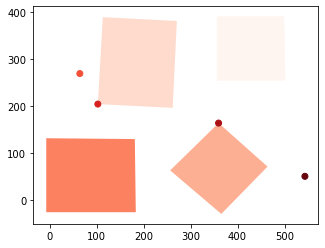

In [9]:
cap=cv2.VideoCapture(1,cv2.CAP_DSHOW)
for i in range (5):
    _, frame = cap.read()
    time.sleep(1)
    print("frame {}".format(i))

#cap.release()
#plt.figure()
#plt.imshow(frame)
#plt.show()

#time.sleep(1)
state=0
margin = 40
switch_next=0
path_iter=1
obst = [0,0,0,0,0]   # measurements from front prox sensors
obstThrL = 2500      # low obstacle threshold to switch state 3->2
obstThrL2 = 3000
obstThrH = 3500      # high obstacle threshold to switch state 2->3  #max 4000
y = [0,0]          # powers given to motor wheels

#init des variables Kalman, et visu de la trace
KF = ExtendedKalmanFilterAstolfi()
KF.init_state_vector(0,0,0,0,0,0,0,0)   #xxx a rendre plus joli
KF.set_time_stamp(time.time())

sensor_package = []
kalman_pos = []

coordThym = []
coordKalm = []

while (cap.isOpened()):
    _, frame = cap.read()
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    #final=vis.img_calibration(img, corner_coord)
    #img= cv2.flip(img, 0)
    if(state==0):
        corner_coord=vis.find_corners(img)
        final=vis.img_calibration(img, corner_coord)
        init=initialisation(final)
        path=glob.global_pathplanning(init[0],init[1],init[2],margin)
        state=2
    #if state==1:
     #   time.sleep(6)
      #  print("time sleep over")
       # _, frame1 = cap.read()
        #plt.figure()
        #plt.imshow(frame1)
        #plt.show()
        #img1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
        #state=2
    if (state==2):
        final=vis.img_calibration(img, corner_coord)
        #plt.figure()
        #plt.imshow(final1)
        #plt.show()
        pos_thym=vis.detectThymio(final)[0]
        angle_thym=vis.directionThymio(final)
        
        #vit_roue_droite = ctrl.read_motors_speed(node,client)[0]#xxx droite ou gauche a verifier
        #vit_roue_gauche = ctrl.read_motors_speed(node,client)[1]#droite ou gauche a verifier
        #sensor_package = [pos_thym[0], pos_thym[1], angle_thym, vit_roue_droite, vit_roue_gauche]
        #E = kalman_step_complet(sensor_package,KF)
        #kalman_pos = [E[0], E[1]]
        #print("kalman pos: {}".format(kalman_pos[0]))
        #angle_kalman=E[2]
        #print("kalman angle: {}".format(angle_kalman))
        
        switch_next=astolfi(pos_thym,path[path_iter],angle_thym,node)
        
        #local avoidance
        # get the proximity sensors values and obstacle update
        prox_horizontal = ctrl.read_prox_sensors(node,client)
        obst = [prox_horizontal[0], prox_horizontal[1], prox_horizontal[2], prox_horizontal[3], prox_horizontal[4]]
        # update the state between state 2 and state 3
        state = local.update_state2(state,obstThrL,obstThrH, obst) 
        
        if(switch_next==1):
            path_iter=path_iter+1
            print("path iter ",path_iter)
            if(path_iter==len(path)):
                ctrl.stopmotors(node)
                print("finish")
                state=4
        
    if(state==3):
        #print("local_nav")  
        #print("obstacles values", obst)
        y_memory = ctrl.read_motors_speed(node,client)
        y = local.local_nav(prox_horizontal,y_memory)
        #print("y ",y)
        ctrl.set_motors(y[0],y[1],node)
        
        # get the proximity sensors values and obstacle update
        prox_horizontal = ctrl.read_prox_sensors(node,client)
        obst = [prox_horizontal[0], prox_horizontal[1], prox_horizontal[2], prox_horizontal[3], prox_horizontal[4]]
        # update the state between state 2 and state 3
        state = local.update_state2(state,obstThrL,obstThrH, obst)
        
    if state==4:
        break
    vis.printGlobalPath(path, final)
   # printThymio(pos_thym, coordThym)
    printThymioKalm(kalman_pos,coordKalm)
    cv2.imshow("results", final)
    if cv2.waitKey(1) & 0xFF ==ord('q'):
        break
        
cap.release()
#cv2.destroyAllWindows()

In [ ]:
print("kalman pos: ",kalman_pos)
print("kalman pos: ", np.asarray(kalman_pos[0][0]))
print("kalman pos: ", np.squeeze(np.asarray(kalman_pos))[0])

In [10]:
ctrl.stopmotors(node)

In [ ]:
test=[[None,None],[None,None]]
if bool(not test[0][0]):
    print("zeub")

In [ ]:
def detectThymio(imgRGB):
    pts=[]
    #p1 is the big circle and p2 the little
    p1=[]
    p2=[]
    lower=np.array([10,30,30])
    upper=np.array([40,255,255])
    nb_iterations=1
    img_hsv = cv2.cvtColor(imgRGB, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(img_hsv, lower, upper)
    img_hsv = cv2.blur(img_hsv,(7,7))
    mask = cv2.erode(mask, None, iterations = nb_iterations)
    mask = cv2.dilate(mask, None, iterations = nb_iterations)
    elements,_ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    print(len(elements))
    if len(elements) > 0:
        #sorting the detected contours by descending area size
        elements.sort(key=cv2.contourArea, reverse=True)
        #finding big circle
        c=elements[0]
        ((x,y),rayon) = cv2.minEnclosingCircle(c)
        #finding little circle
        c2=elements[1]
        ((x2,y2),rayon2) = cv2.minEnclosingCircle(c2)
        p1=[x,y]
        p2=[x2,y2]
        pts=[p1,p2]
    return pts

#print(detectThymio(final))
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
corner_coord=vis.find_corners(frame)
final=vis.img_calibration(frame, corner_coord)
print(detectThymio(final)[0])

In [ ]:
print(init)

In [ ]:
# Navigation initialisation
checkp=1           # goal checkpoint
actual_angle=0     # angle to xy axis
y = [0,0]          # powers given to motor wheels

# FSM initialisation
state = 2          # States FSM 0=global nav, 1=local nav
obst = [0,0,0,0,0]   # measurements from front prox sensors
obstThrL = 2500      # low obstacle threshold to switch state 3->2
obstThrL2 = 3000
obstThrH = 3500      # high obstacle threshold to switch state 2->3 

def update_state(state,obstThrL,obstThrH, obst):
    if state == 2: 
        # switch from goal tracking to obst avoidance if obstacle detected
        if (obst[2] > obstThrH):
            state = 3
            print("change state to local")
        elif (obst[1] > obstThrH):
            state = 3
            print("change state to local")
        elif (obst[3] > obstThrH):
            state = 3
            print("change state to local")
        elif (obst[0] > obstThrH):
            state = 3
            print("change state to local")
        elif (obst[4] > obstThrH):
            state = 3
            print("change state to local")
    elif state == 3:
        if obst[2] < obstThrL:
            if obst[1] < obstThrL:
                if obst[3] < obstThrL:
                    if obst[0] < obstThrL:
                        if obst[4] < obstThrL:
                            # switch from obst avoidance to goal tracking if obstacle got unseen
                            state = 2
                            print("change state to global")
    return state

while True:
    
    # get the proximity sensors values and obstacle update
    prox_horizontal = ctrl.read_prox_sensors(node,client)
    obst = [prox_horizontal[0], prox_horizontal[1], prox_horizontal[2], prox_horizontal[3], prox_horizontal[4]]
    
    # update the state and speed motors values
    state = update_state(state,obstThrL,obstThrH, obst)
    y = ctrl.read_motors_speed(node,client)
    
    print("state", state)

    if state == 2:
        
        """
        # With positon estimation when vision and/or kalman ready
        
        actual,angle = getting_vis()
        pred_pos,pred_angle = kalman(actual, angle)
        
        actual_pos=pred_pos
        actual_angle=pred_angle
        
        if actual_pos == checkpoints[checkp]: # other option: if (actual_pos - checkpoints[checkp]) < error
            checkp=checkp+1
        goal_pos=checkpoints[checkp]
        
        y = ctrl.astolfi2(actual_pos, goal_pos, actual_angle, node)
        
        """
        y = [100,100]
        ctrl.set_motors(y[0],y[1],node)

    elif state == 3:
        print("obstacles values", obst)
        y = local.local_nav(prox_horizontal,y)
        print("y ",y)
        ctrl.set_motors(y[0],y[1],node)

ctrl.stopmotors(node)

In [ ]:
ctrl.stopmotors(node)